Reference: Molecular Similarity-Based Domain Applicability Metric Efficiently Identifies Out-of-Domain Compounds

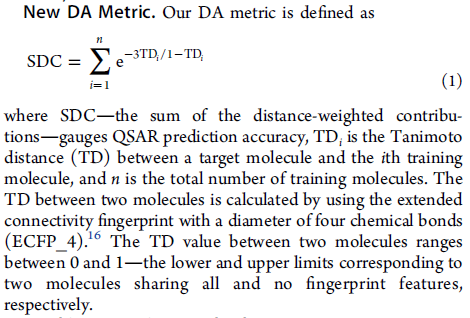

In [1]:
from IPython.display import Image
Image("da_metric.PNG")

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import oddt
from oddt.fingerprints import ECFP
import numpy as np

In [3]:
# mols = oddt.toolkit.readfile('smi', 'data/test_smiles.smi')

In [4]:
smiles = []

with open("data/test_smiles.smi") as f:
    for line in f.read().splitlines():
        if line:
            smiles.append(line)

# Convert into Canonical SMILES
smiles = [Chem.CanonSmiles(s) for s in smiles]

train_smiles = smiles[:-50]
test_smiles = smiles[-50:]

In [5]:
class AD:
    def __init__(self, train_data):
        if not isinstance(train_data, list) or not train_data or len(train_data) < 10:
            raise Exception("Training data should be a list of at least 10 SMILES")
        
        # Canonicalize the SMILES
        self.train_data = [Chem.CanonSmiles(sm) for sm in smiles if len(sm) > 0]
        self.fingerprints = []
    
    def fit(self):
        # Find the fingerprints
        for sm in self.train_data:
            mol = Chem.MolFromSmiles(sm)
            if not mol:
                continue
            self.fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2))
            
        if len(self.fingerprints) < 5:
            raise Exception(f"Not enough fingerprints can be generated from the training data (len={len(self.fingerprints)})")
    
    def get_score(self, smiles):
        if not self.fingerprints:
            raise Exception("Please run fit() first.")
            
        smiles = Chem.CanonSmiles(smiles)
        mol = Chem.MolFromSmiles(smiles)
        
        if not mol:
            raise Exception("Invalid SMILES.")
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2)
        scores = []
        
        for train_fp in self.fingerprints:
            scores.append(DataStructs.TanimotoSimilarity(train_fp, fp))
        
        scores = np.array(scores)
        return np.sum(np.exp(-1 * (3 * scores) / (1 - scores)))

In [6]:
ad = AD(train_data=train_smiles)
ad.fit()

In [7]:
s = ad.get_score(test_smiles[0])

/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


In [8]:
[ad.get_score(s) for s in test_smiles]

/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


[586.4579839165169,
 563.4608265006243,
 518.9706610413874,
 552.7698279640579,
 574.7077505035159,
 559.6735035790989,
 553.7085362381607,
 539.9734137993469,
 628.9368587414799,
 551.5707290705781,
 644.9410441985235,
 581.1768119266565,
 593.1122425452951,
 566.4430096224082,
 585.772507926647,
 657.5456197297331,
 560.8358461998912,
 624.2373950458827,
 627.1435412042973,
 570.8345431830164,
 625.8294205141888,
 631.2825437624264,
 586.4928692475731,
 634.1917794386723,
 579.5697151858467,
 564.7933394998604,
 557.618783578186,
 580.1563855372335,
 581.1898971350586,
 701.0424396563225,
 618.5578050192795,
 619.3515349276149,
 534.2750165877382,
 598.6874732105996,
 632.8544655506485,
 654.1703370957363,
 619.4665169446939,
 586.5854624320942,
 615.2395790514635,
 561.5134140346667,
 519.1452794260583,
 526.5592921972003,
 554.3929158683895,
 546.7355973927779,
 600.1644868194996,
 546.4395798751284,
 558.8821298782021,
 645.5195008048396,
 554.1322407631526,
 572.7903485932162]

In [15]:
from glob import glob
import pandas as pd

In [16]:
smiles_file = 'data/3CL/3CL-balanced_randomsplit7_70_15_15_'
train_smiles = pd.read_csv(smiles_file + 'tr.csv', usecols=[4])
test_smiles = pd.read_csv(smiles_file + 'te.csv', usecols = [4])

In [23]:
ad = AD(train_data=train_smiles.SMILES.to_list())
ad.fit()

In [25]:
sdc_scores = test_smiles.SMILES.apply(lambda x: ad.get_score(x))

In [26]:
print(sdc_scores)

0     738.893012
1     623.633057
2     736.659310
3     801.920661
4     764.090945
         ...    
82    667.809641
83    690.396733
84    662.528007
85    717.996757
86    787.270942
Name: SMILES, Length: 87, dtype: float64
